In [1]:
import os
import numpy as np
import scipy
import sys
import matplotlib.gridspec as gridspec
import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from scipy.optimize import curve_fit
from astropy.io import fits
import matplotlib.pyplot as plt
import emcee
import corner
from tabulate import tabulate
from astropy.modeling.models import Moffat2D

%matplotlib inline

# I. Image

In [2]:
hdul = fits.open('/home/tehan/Documents/ShaneAO/Binaries/TIC_456334158_final_filter_Ks.fits')

212 264


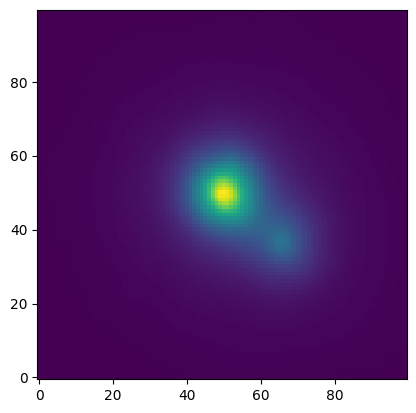

In [3]:
image = hdul[0].data
peak = np.where(image == np.max(image))
delta_x = peak[0][0] - 50
delta_y = peak[1][0] - 50
print(delta_x, delta_y)
image = hdul[0].data[delta_x:delta_x+100, delta_y:delta_y+100]
peak = np.where(image == np.max(image))
np.shape(image)
plt.imshow(image, origin='lower')
# plt.xlim(250,350)
# plt.ylim(200,300)

# II. 2D Gaussian fit
## 1. scipy curve_fit

Fitted parameters for Gaussian 1:
Amplitude: 672.5164629060043
Mean (x, y): 49.61292983747325 50.25979351326851
Standard deviation (sigma_x, sigma_y): 6.980319434033407 7.642109579313295

Fitted parameters for Gaussian 2:
Amplitude: 230.33532075781045
Mean (x, y): 65.32770721711672 37.49848629876259
Standard deviation (sigma_x, sigma_y): 9.111800489825244 10.310143365511145


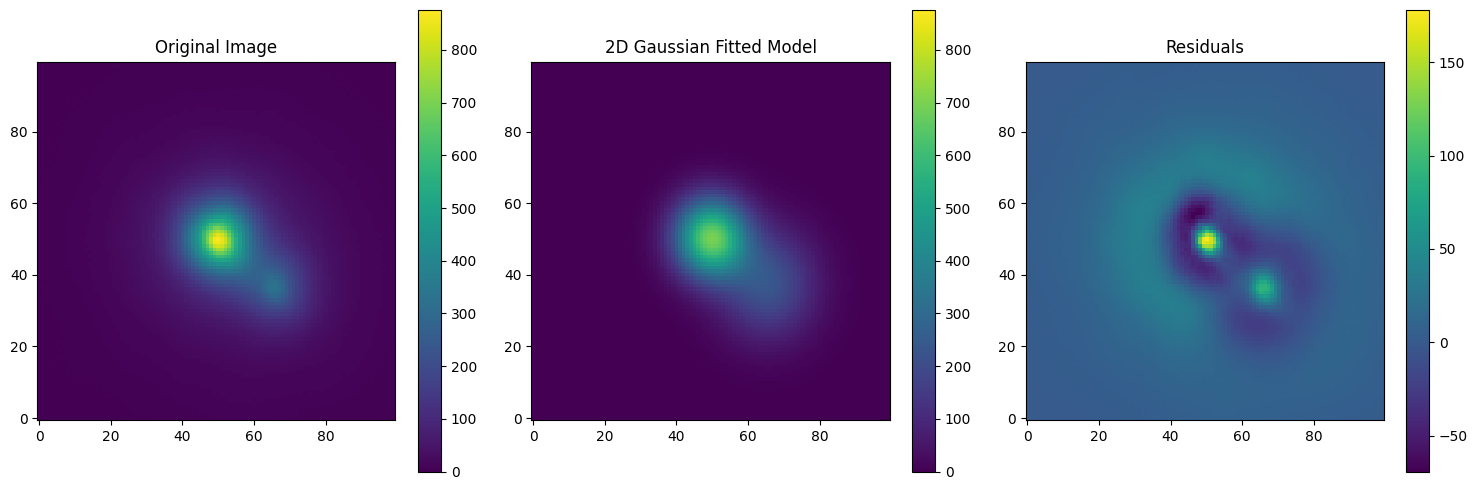

In [4]:
x, y = np.meshgrid(np.arange(np.shape(image)[0]), np.arange(np.shape(image)[1]))
# Define a function to represent the double Gaussian
def double_gaussian(xy, amp1, x_mean1, y_mean1, sigma_x1, sigma_y1, amp2, x_mean2, y_mean2, sigma_x2, sigma_y2):
    x, y = xy
    gauss1 = amp1 * np.exp(-((x - x_mean1) ** 2 / (2 * sigma_x1 ** 2) + (y - y_mean1) ** 2 / (2 * sigma_y1 ** 2)))
    gauss2 = amp2 * np.exp(-((x - x_mean2) ** 2 / (2 * sigma_x2 ** 2) + (y - y_mean2) ** 2 / (2 * sigma_y2 ** 2)))
    return gauss1 + gauss2

# Initial guess for parameters
initial_guess = [np.max(image), peak[1][0], peak[0][0], 4, 4, 
                 np.max(image) / 10, 330 - delta_y, 250 - delta_x, 0.5, 0.5]

# Fit the double Gaussian model to the data
popt, pcov = curve_fit(double_gaussian, (x.ravel(), y.ravel()), image.ravel(), p0=initial_guess)

# Extracting fitted parameters
amp1, x_mean1, y_mean1, sigma_x1, sigma_y1, amp2, x_mean2, y_mean2, sigma_x2, sigma_y2 = popt

# Calculate the fitted model and residuals
fitted_model = double_gaussian((x, y), *popt)
residuals = image - fitted_model

# Print fitted parameters
print("Fitted parameters for Gaussian 1:")
print("Amplitude:", amp1)
print("Mean (x, y):", x_mean1, y_mean1)
print("Standard deviation (sigma_x, sigma_y):", sigma_x1, sigma_y1)
print("\nFitted parameters for Gaussian 2:")
print("Amplitude:", amp2)
print("Mean (x, y):", x_mean2, y_mean2)
print("Standard deviation (sigma_x, sigma_y):", sigma_x2, sigma_y2)

# Plot the original image, the fitted model, and the residuals
plt.figure(figsize=(15, 5))
cmin = min(np.min(image), np.min(fitted_model))
cmax = max(np.max(image), np.max(fitted_model))
# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(image, origin='lower', cmap='viridis', interpolation='nearest', vmin=cmin, vmax=cmax)
plt.title('Original Image')
plt.colorbar()

# Plot the fitted model
plt.subplot(1, 3, 2)
plt.imshow(fitted_model, origin='lower', cmap='viridis', interpolation='nearest', vmin=cmin, vmax=cmax)
plt.title('2D Gaussian Fitted Model')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(residuals, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Residuals')
plt.colorbar()

plt.tight_layout()
plt.show()

# II. 2D Gaussian fit
## 2. emcee

100%|██████████| 10000/10000 [00:40<00:00, 246.49it/s]


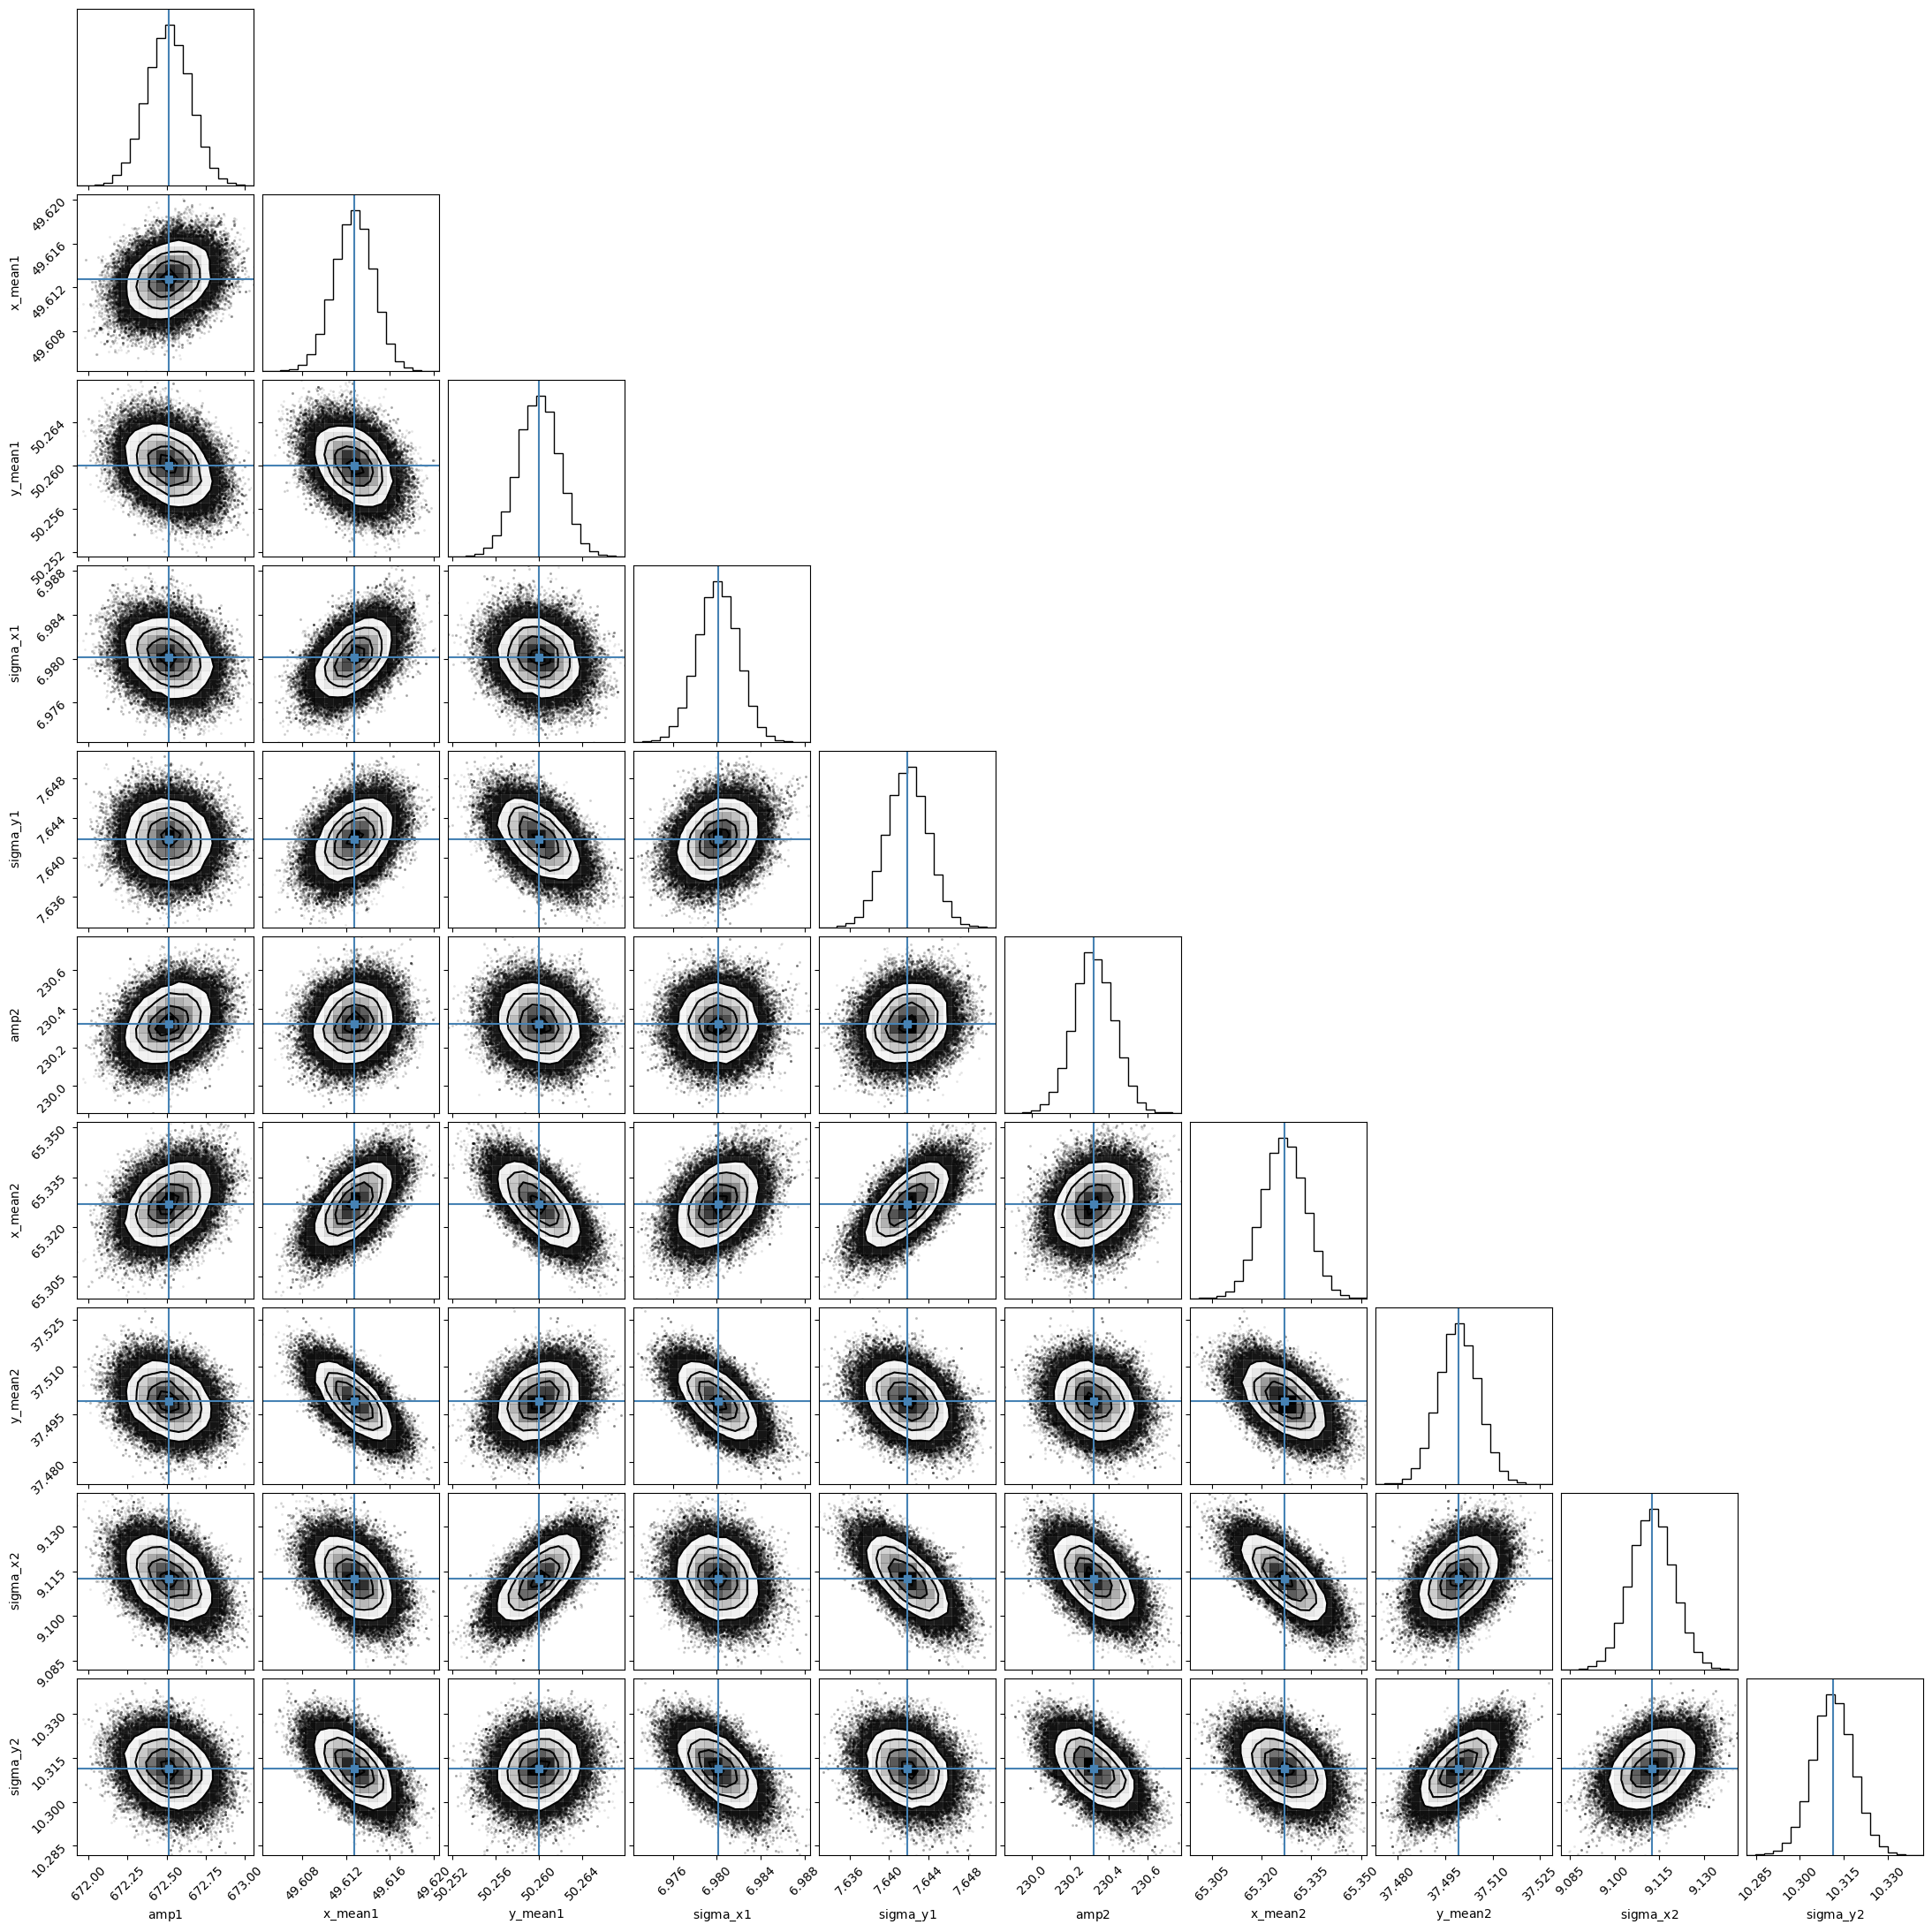

In [5]:
# Initial guess for parameters from previous
initial_guess = popt

# Define log likelihood function for the MCMC sampler
def log_likelihood(params, xy, data):
    model = double_gaussian(xy, *params)
    return -0.5 * np.sum((data - model)**2)

# Define log prior function for the MCMC sampler
def log_prior(params):
    # Assuming flat priors for all parameters
    return 0.0

# Define log probability function for the MCMC sampler
def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, (x.ravel(), y.ravel()), image.ravel())

# Set up the MCMC sampler
nwalkers = 32
ndim = len(initial_guess)
nsteps = 10000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Initialize walkers
p0 = [initial_guess + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

# Run the MCMC sampler
sampler.run_mcmc(p0, nsteps, progress=True)

# Get samples from the MCMC chain, discarding the burn-in period
burn_in = int(0.2 * nsteps)  # Define the burn-in period as 20% of the total steps
samples = sampler.get_chain(flat=True, discard=burn_in)

# Extract mean and standard deviation of parameters from samples
param_means = np.mean(samples, axis=0)
param_std = np.std(samples, axis=0)

# Plot corner plot to visualize parameter distributions
labels = [r"$\mathrm{amp1}$", r"$\mathrm{x\_mean1}$", r"$\mathrm{y\_mean1}$",
          r"$\mathrm{sigma\_x1}$", r"$\mathrm{sigma\_y1}$", r"$\mathrm{amp2}$",
          r"$\mathrm{x\_mean2}$", r"$\mathrm{y\_mean2}$", r"$\mathrm{sigma\_x2}$",
          r"$\mathrm{sigma\_y2}$"]
corner_plot = corner.corner(samples, labels=labels, truths=param_means, figsize=(10, 10))

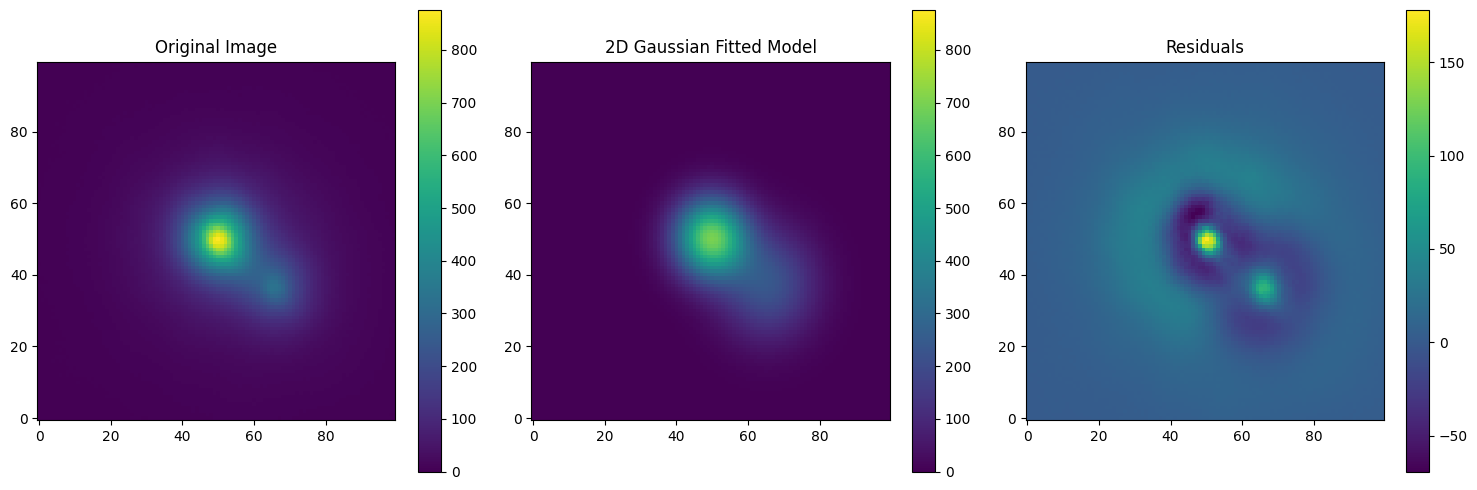

\begin{tabular}{lrr}
\hline
 Parameter            &      Mean &   Std. Dev. \\
\hline
 $\mathrm{amp1}$      & 672.513   &  0.137465   \\
 $\mathrm{x\_mean1}$  &  49.6127  &  0.00178367 \\
 $\mathrm{y\_mean1}$  &  50.26    &  0.00189179 \\
 $\mathrm{sigma\_x1}$ &   6.98011 &  0.00183725 \\
 $\mathrm{sigma\_y1}$ &   7.64184 &  0.00209708 \\
 $\mathrm{amp2}$      & 230.324   &  0.104142   \\
 $\mathrm{x\_mean2}$  &  65.3268  &  0.00646467 \\
 $\mathrm{y\_mean2}$  &  37.4993  &  0.00621066 \\
 $\mathrm{sigma\_x2}$ &   9.11276 &  0.00716117 \\
 $\mathrm{sigma\_y2}$ &  10.3114  &  0.00688386 \\
\hline
\end{tabular}


In [6]:
# Extract parameter names
param_names = [r"$\mathrm{amp1}$", r"$\mathrm{x\_mean1}$", r"$\mathrm{y\_mean1}$",
               r"$\mathrm{sigma\_x1}$", r"$\mathrm{sigma\_y1}$", r"$\mathrm{amp2}$",
               r"$\mathrm{x\_mean2}$", r"$\mathrm{y\_mean2}$", r"$\mathrm{sigma\_x2}$",
               r"$\mathrm{sigma\_y2}$"]

# Combine parameter names, means, and standard deviations into a table
table_data = [[name, mean, std] for name, mean, std in zip(param_names, param_means, param_std)]

# Print the table in LaTeX style
latex_table = tabulate(table_data, headers=["Parameter", "Mean", "Std. Dev."], tablefmt="latex_raw")

# Plot the original image, the fitted model, and the residuals
plt.figure(figsize=(15, 5))
cmin = min(np.min(image), np.min(fitted_model))
cmax = max(np.max(image), np.max(fitted_model))
# Plot the original image
plt.subplot(1, 3, 1)
im = plt.imshow(image, origin='lower', cmap='viridis', interpolation='nearest', vmin=cmin, vmax=cmax)
plt.title('Original Image')
plt.colorbar(im)

# Plot the fitted model
fitted_model = double_gaussian((x, y), *param_means)
plt.subplot(1, 3, 2)
im = plt.imshow(fitted_model, origin='lower', cmap='viridis', interpolation='nearest', vmin=cmin, vmax=cmax)
plt.title('2D Gaussian Fitted Model')
plt.colorbar(im)

# Plot the residuals
residuals = image - fitted_model
plt.subplot(1, 3, 3)
im = plt.imshow(residuals, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Residuals')
plt.colorbar(im)

# Adjust colorbar limits to match the first two plots


plt.tight_layout()
plt.show()

# Print the LaTeX table
print(latex_table)

# III. 2D Moffat fit
## 1. scipy curve_fit 

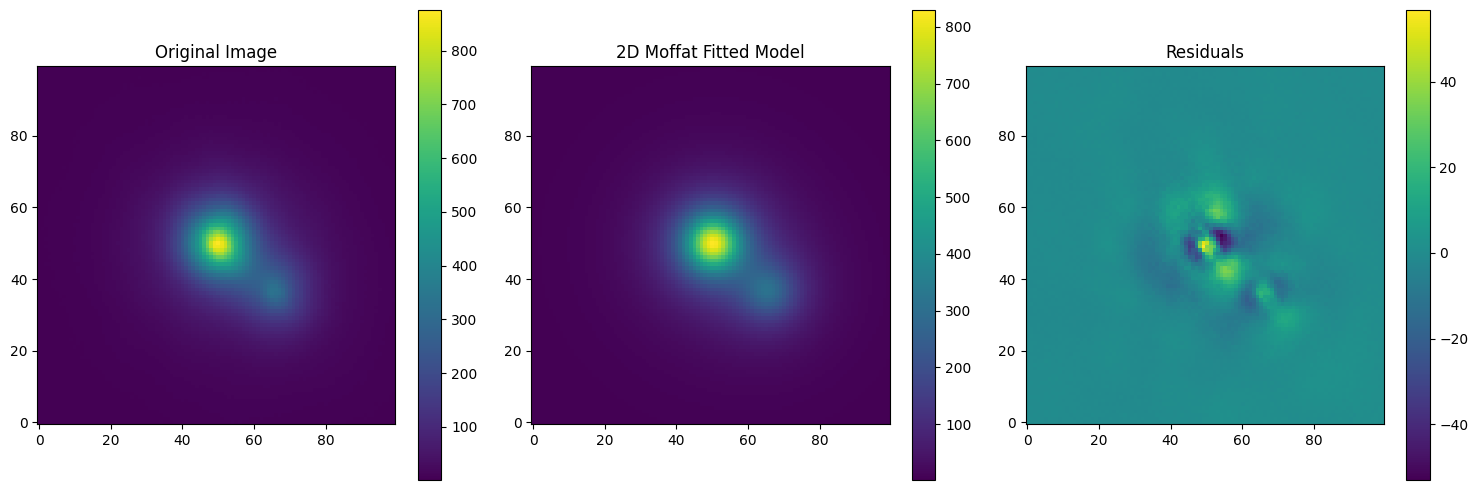

Fitted parameters for Moffat 1:
Amplitude: 814.9213608510262
Mean (x, y): 50.199069971225576 49.86602862515261
Gamma: 9.438154596145099
Alpha: 1.587345105615702

Fitted parameters for Moffat 2:
Amplitude: 263.06744229423015
Mean (x, y): 65.76852039362096 36.42549898313632
Gamma: 10.447638975524814
Alpha: 1.7638330621216665


In [7]:
# Define a function to represent two Moffat profiles
def double_moffat(xy, amp1, x_mean1, y_mean1, gamma1, alpha1, amp2, x_mean2, y_mean2, gamma2, alpha2):
    moffat1 = Moffat2D(amplitude=amp1, x_0=x_mean1, y_0=y_mean1, gamma=gamma1, alpha=alpha1)(xy[0], xy[1])
    moffat2 = Moffat2D(amplitude=amp2, x_0=x_mean2, y_0=y_mean2, gamma=gamma2, alpha=alpha2)(xy[0], xy[1])
    return moffat1 + moffat2

# Initial guess for parameters
peak = np.where(image == np.max(image))
initial_guess = [np.max(image), peak[1][0], peak[0][0], 1, 1, 
                 np.max(image) / 10, 330 - delta_y, 250 - delta_x, 1, 1]

# Fit the double Moffat model to the data using scipy.curve_fit
popt, pcov = curve_fit(double_moffat, (x.ravel(), y.ravel()), image.ravel(), p0=initial_guess)

# Extracting fitted parameters
amp1, x_mean1, y_mean1, gamma1, alpha1, amp2, x_mean2, y_mean2, gamma2, alpha2 = popt

# Calculate the fitted model and residuals
fitted_model = double_moffat((x, y), *popt)
residuals = image - fitted_model

# Plot the original image, the fitted model, and the residuals
plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(image, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Original Image')
plt.colorbar()

# Plot the fitted model
plt.subplot(1, 3, 2)
plt.imshow(fitted_model, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('2D Moffat Fitted Model')
plt.colorbar()

# Plot the residuals
plt.subplot(1, 3, 3)
plt.imshow(residuals, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Residuals')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print fitted parameters
print("Fitted parameters for Moffat 1:")
print("Amplitude:", amp1)
print("Mean (x, y):", x_mean1, y_mean1)
print("Gamma:", gamma1)
print("Alpha:", alpha1)

print("\nFitted parameters for Moffat 2:")
print("Amplitude:", amp2)
print("Mean (x, y):", x_mean2, y_mean2)
print("Gamma:", gamma2)
print("Alpha:", alpha2)

# III. 2D Moffat fit
## 2. emcee

100%|██████████| 10000/10000 [02:49<00:00, 59.00it/s]


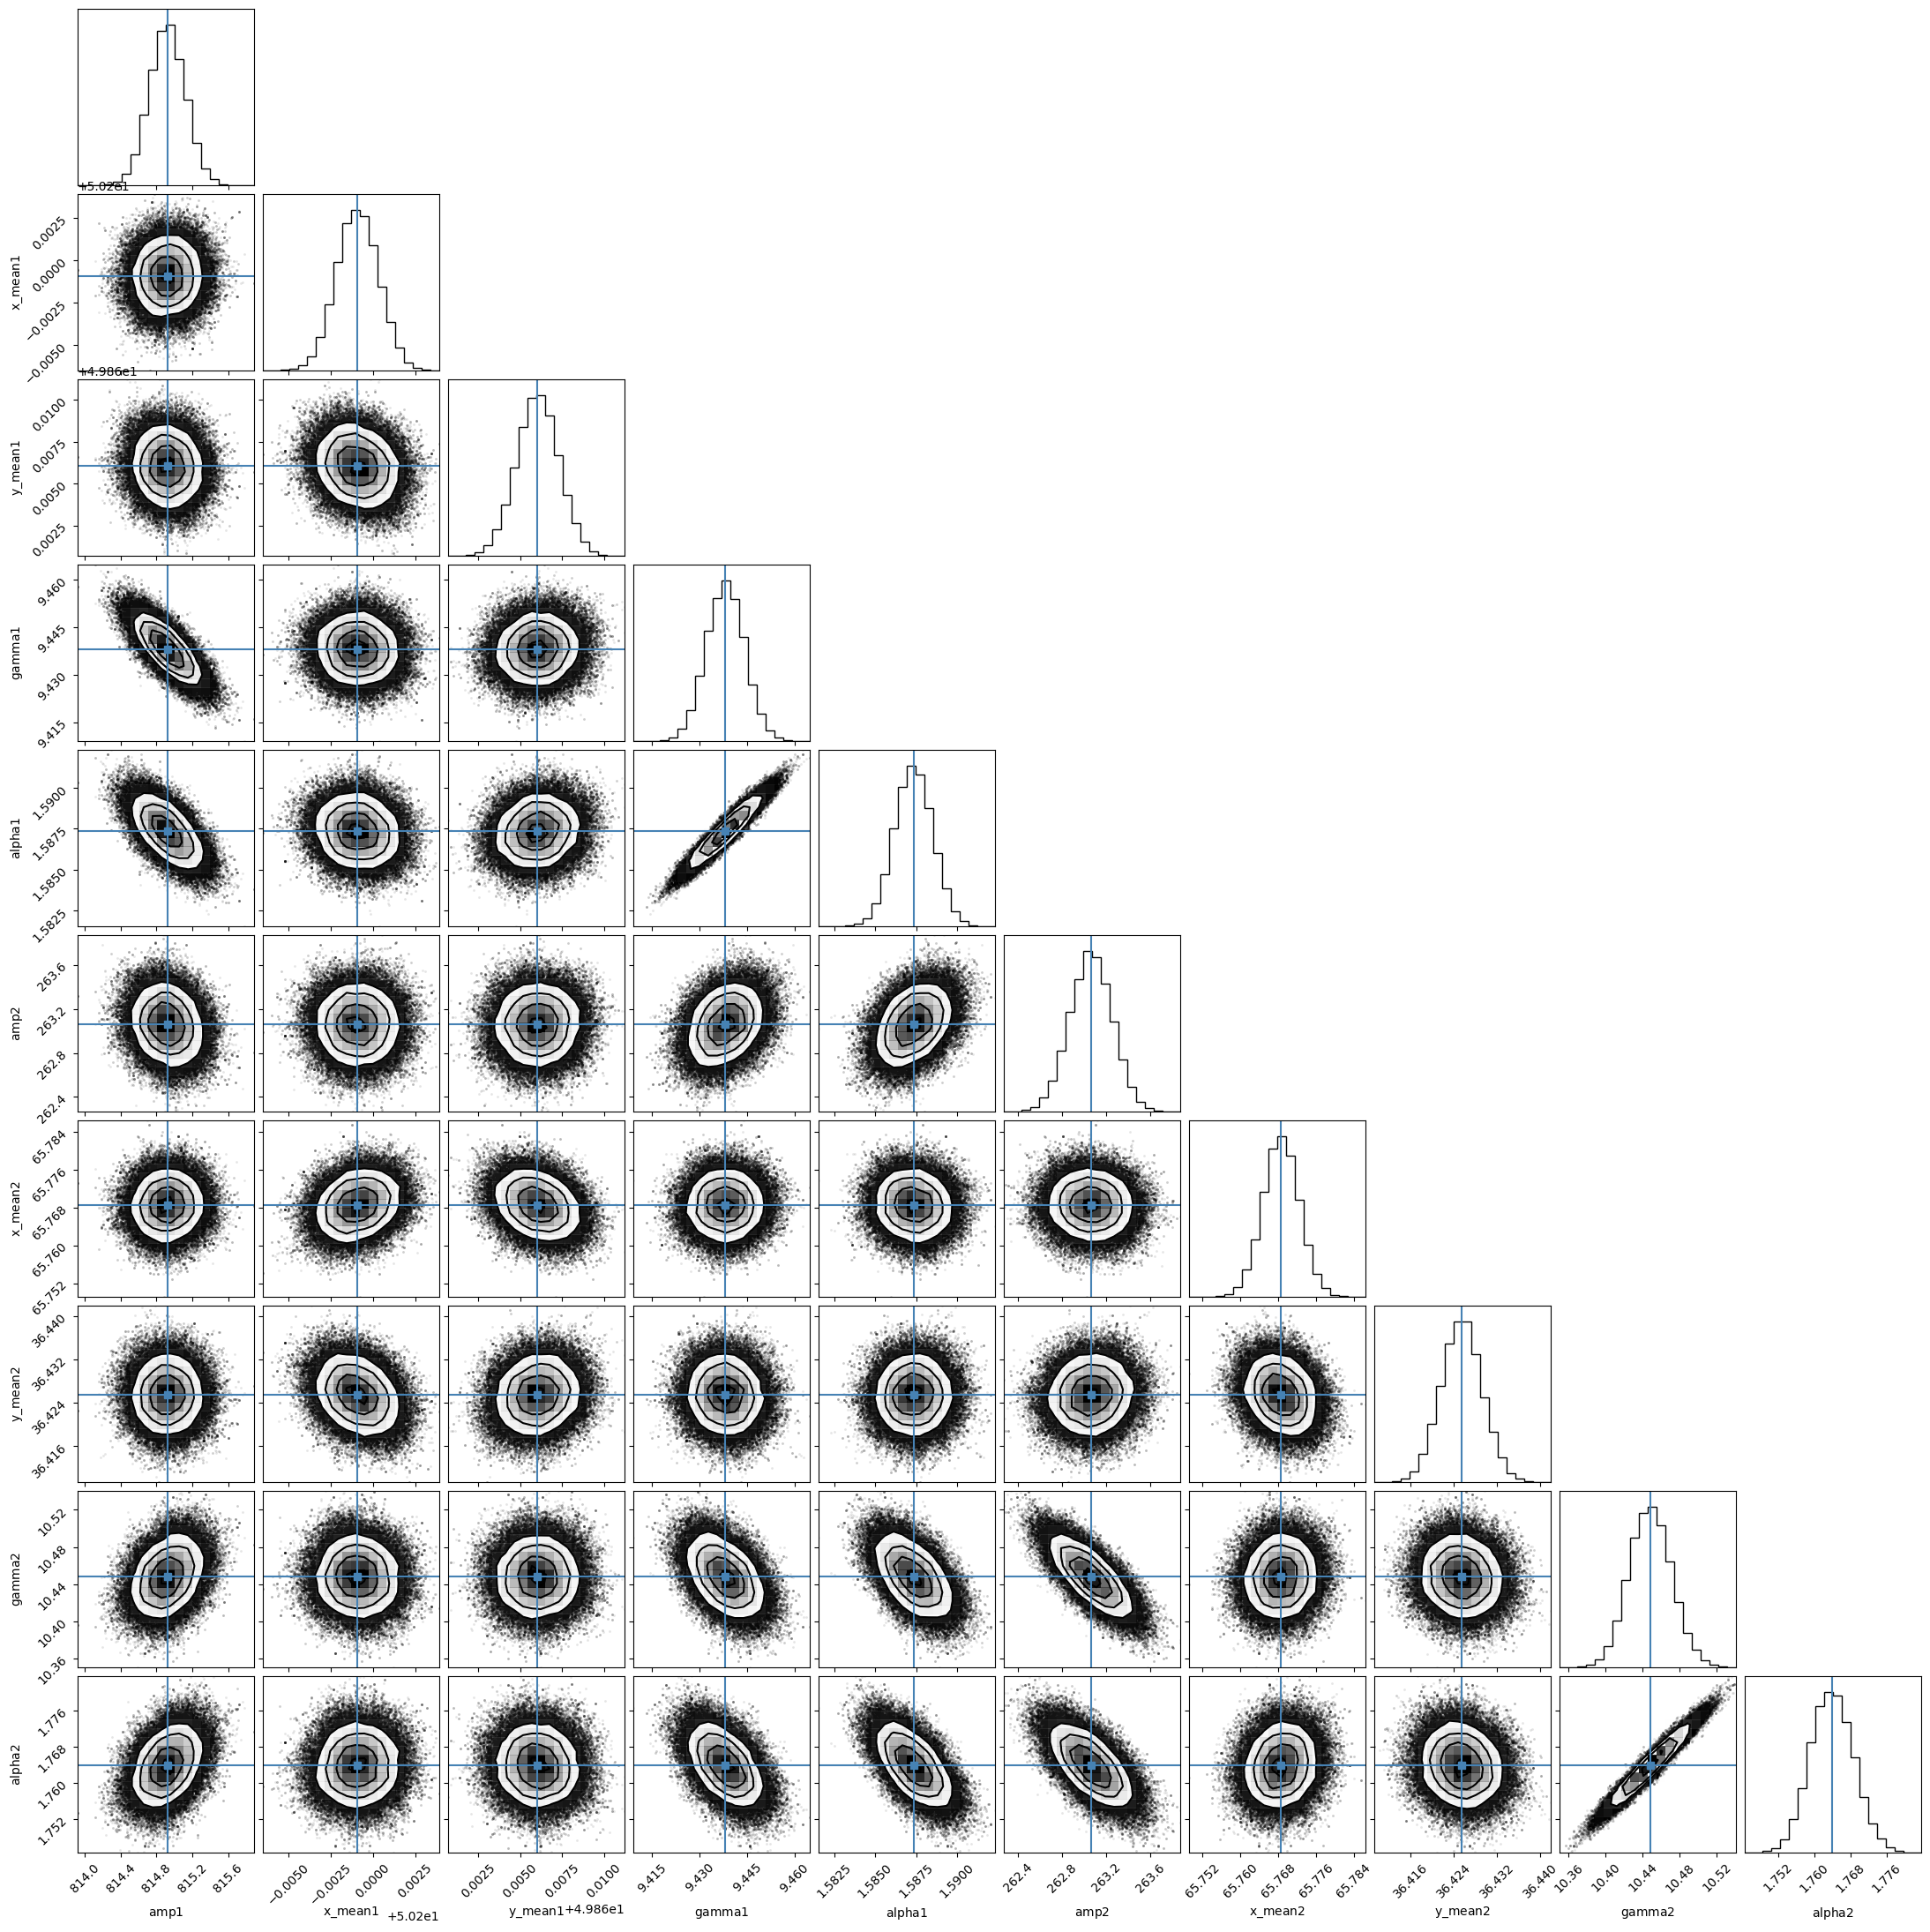

In [8]:
# Initial guess for parameters from previous
initial_guess = popt

# Define log likelihood function for the MCMC sampler
def log_likelihood(params, xy, data):
    model = double_moffat(xy, *params)
    return -0.5 * np.sum((data - model)**2)

# Define log prior function for the MCMC sampler
def log_prior(params):
    # Assuming flat priors for all parameters
    return 0.0

# Define log probability function for the MCMC sampler
def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, (x.ravel(), y.ravel()), image.ravel())

# Set up the MCMC sampler
nwalkers = 32
ndim = len(initial_guess)
nsteps = 10000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Initialize walkers
p0 = [initial_guess + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

# Run the MCMC sampler
sampler.run_mcmc(p0, nsteps, progress=True)

# Get samples from the MCMC chain, discarding the burn-in period
burn_in = int(0.2 * nsteps)  # Define the burn-in period as 20% of the total steps
samples = sampler.get_chain(flat=True, discard=burn_in)

# Extract mean and standard deviation of parameters from samples
param_means = np.mean(samples, axis=0)
param_std = np.std(samples, axis=0)

# Plot corner plot to visualize parameter distributions
labels = [r"$\mathrm{amp1}$", r"$\mathrm{x\_mean1}$", r"$\mathrm{y\_mean1}$",
          r"$\mathrm{gamma1}$", r"$\mathrm{alpha1}$", r"$\mathrm{amp2}$",
          r"$\mathrm{x\_mean2}$", r"$\mathrm{y\_mean2}$", r"$\mathrm{gamma2}$",
          r"$\mathrm{alpha2}$"]
corner_plot = corner.corner(samples, labels=labels, truths=param_means, figsize=(10, 10))

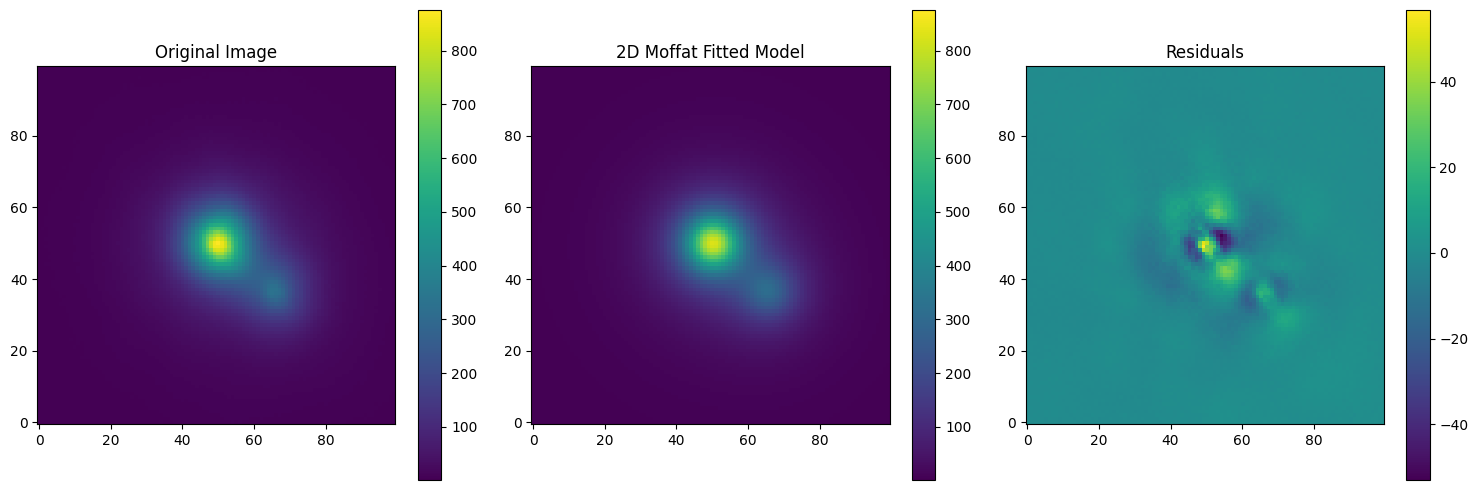

\begin{tabular}{lrr}
\hline
 Parameter            &      Mean &   Std. Dev. \\
\hline
 $\mathrm{amp1}$      & 814.921   &  0.198759   \\
 $\mathrm{x\_mean1}$  &  50.1991  &  0.00123102 \\
 $\mathrm{y\_mean1}$  &  49.866   &  0.0012515  \\
 $\mathrm{sigma\_x1}$ &   9.43818 &  0.00598608 \\
 $\mathrm{sigma\_y1}$ &   1.58734 &  0.00116026 \\
 $\mathrm{amp2}$      & 263.059   &  0.191178   \\
 $\mathrm{x\_mean2}$  &  65.7686  &  0.00383203 \\
 $\mathrm{y\_mean2}$  &  36.4254  &  0.00377874 \\
 $\mathrm{sigma\_x2}$ &  10.4481  &  0.0227556  \\
 $\mathrm{sigma\_y2}$ &   1.76391 &  0.004757   \\
\hline
\end{tabular}


In [9]:
# Extract parameter names
param_names = [r"$\mathrm{amp1}$", r"$\mathrm{x\_mean1}$", r"$\mathrm{y\_mean1}$",
               r"$\mathrm{sigma\_x1}$", r"$\mathrm{sigma\_y1}$", r"$\mathrm{amp2}$",
               r"$\mathrm{x\_mean2}$", r"$\mathrm{y\_mean2}$", r"$\mathrm{sigma\_x2}$",
               r"$\mathrm{sigma\_y2}$"]

# Combine parameter names, means, and standard deviations into a table
table_data = [[name, mean, std] for name, mean, std in zip(param_names, param_means, param_std)]

# Print the table in LaTeX style
latex_table = tabulate(table_data, headers=["Parameter", "Mean", "Std. Dev."], tablefmt="latex_raw")

# Plot the original image, the fitted model, and the residuals
plt.figure(figsize=(15, 5))
cmin = min(np.min(image), np.min(fitted_model))
cmax = max(np.max(image), np.max(fitted_model))
# Plot the original image
plt.subplot(1, 3, 1)
im = plt.imshow(image, origin='lower', cmap='viridis', interpolation='nearest', vmin=cmin, vmax=cmax)
plt.title('Original Image')
plt.colorbar(im)

# Plot the fitted model
fitted_model = double_moffat((x, y), *popt)
plt.subplot(1, 3, 2)
im = plt.imshow(fitted_model, origin='lower', cmap='viridis', interpolation='nearest', vmin=cmin, vmax=cmax)
plt.title('2D Moffat Fitted Model')
plt.colorbar(im)

# Plot the residuals
residuals = image - fitted_model
plt.subplot(1, 3, 3)
im = plt.imshow(residuals, origin='lower', cmap='viridis', interpolation='nearest')
plt.title('Residuals')
plt.colorbar(im)

# Adjust colorbar limits to match the first two plots


plt.tight_layout()
plt.show()

# Print the LaTeX table
print(latex_table)

# IV. Get RA, dec for companion

Primary   - RA: 134.90364738385333 +- 1.934679179424268e-08 Dec: 53.737447431134655  +- 1.1475556714266196e-08 
Secondary - RA: 134.90343275356406 +- 6.129015599395549e-08 Dec: 53.737300397086315  +- 3.453083622574307e-08 
Delta RA  =  -0.0002146302892640506
Delta DEC =  -0.0001470340483393784


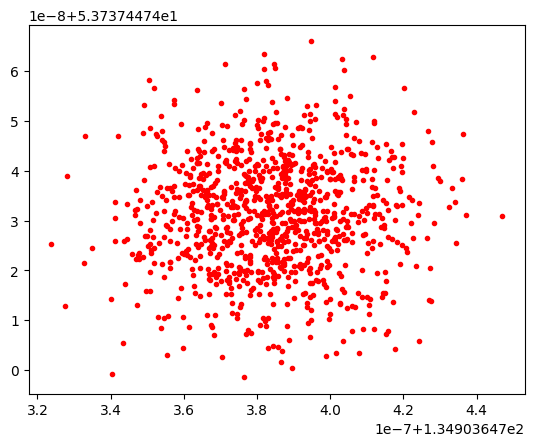

In [12]:
# Define pixel coordinates of the stars
wcs = WCS(hdul[0].header)
size = 1000
np.random.seed(0)
x_1 = np.random.normal(table_data[1][1], table_data[1][2], size)
y_1 = np.random.normal(table_data[2][1], table_data[2][2], size)
x_2 = np.random.normal(table_data[6][1], table_data[6][2], size)
y_2 = np.random.normal(table_data[7][1], table_data[7][2], size)
ra_star1, dec_star1 = wcs.all_pix2world(*(x_1, y_1), 0)
ra_star2, dec_star2 = wcs.all_pix2world(*(x_2, y_2), 0)
plt.plot(ra_star1, dec_star1, 'r.')
# plt.plot(ra_star2, dec_star2, 'b.')

coord_star1 = SkyCoord(ra=np.mean(ra_star1)*u.degree, dec=np.mean(dec_star1)*u.degree, frame='icrs')
coord_star2 = SkyCoord(ra=np.mean(ra_star2)*u.degree, dec=np.mean(dec_star2)*u.degree, frame='icrs')

# Print the RA and Dec of the first and second stars
print(f"Primary   - RA: {np.mean(ra_star1)} +- {np.std(ra_star1)} Dec: {np.mean(dec_star1)}  +- {np.std(dec_star1)} ")
print(f"Secondary - RA: {np.mean(ra_star2)} +- {np.std(ra_star2)} Dec: {np.mean(dec_star2)}  +- {np.std(dec_star2)} ")
print(r"Delta RA  = ", np.mean(ra_star2) - np.mean(ra_star1))
print(r"Delta DEC = ", np.mean(dec_star2) - np.mean(dec_star1))
#Primary   - RA: 134.9036473839959 Dec: 53.737447431026105
# Secondary - RA: 134.90343275724183 Dec: 53.73730039502194

In [13]:
ra_hms_star1 = coord_star1.ra.to_string(unit=u.hour, sep=':', precision=2, pad=True)
dec_dms_star1 = coord_star1.dec.to_string(unit=u.deg, sep=':', precision=1, pad=True, alwayssign=True)

ra_hms_star2 = coord_star2.ra.to_string(unit=u.hour, sep=':', precision=2, pad=True)
dec_dms_star2 = coord_star2.dec.to_string(unit=u.deg, sep=':', precision=1, pad=True, alwayssign=True)

# Print the converted RA and Dec
print("Primary   - RA:", ra_hms_star1, "Dec:", dec_dms_star1)
print("Secondary - RA:", ra_hms_star2, "Dec:", dec_dms_star2)

Primary   - RA: 08:59:36.88 Dec: +53:44:14.8
Secondary - RA: 08:59:36.82 Dec: +53:44:14.3


Gaia DR2: RA/Dec (J2000, epoch 2015.5): 08:59:35.42 +53:43:47.58 (134.897579°53.729883°) 

Proper Motion (mas/yr):  
RA:	-275.51	 Dec:	-199.29

Gaia DR3: Equatorial ICRS (RA,DEC) at epoch 2016	134.8975225561, 53.7298615223

In [14]:
15/3600

0.004166666666666667

In [15]:
1/3600

0.0002777777777777778